# <u> Final NFL Spread Betting Model <u/>

## Introduction

I am using a historical dataset of NFL games (regular season and playoffs) to analyze the impacts of certain variables such as home team, playoff game, weather, etc. on the outcome of the spread in any given NFL game (the team that wins after the spreadd is accounted for).

The spread of a football game is a number that allows fans to gamble on the outcome of the game while accounting for the skill differences between each teams. For example, if the best team in the league is playing the worst, the spread might be **-14**. This means that if I bet on the best team in the league, they must win by at more than 14 points for me to receive winnings. Conversely, I could bet on the worst team who would have the opposite spread of **+14**. In order to win this bet, the worst team would have to either win the game outright or lose by less than 14 points.

This concept is interesting to me because in the modern sports era, thousands of statistics are collected from every game. Since the spread is an arbitrary number set by casinos, it should be possible to find trends in the game statistics that can (with the right model) accurately predict the outcome of a given NFL spread.

My goal is for the model to beat random chance. The beauty of sports is that despite all the statistics and predictions that exist, there is still an enormous amount of randomness associated with the games, and especially the spreads. If I can build a model that is consistently better than random chance, the user of the model could turn a reliable profit by using it long-term.

#### Research Question & Findings

Can I use historical data of NFL games to create a model that can accurately determine the probability that the team that is the favorite will cover the spread? And, can I use this model to create confidence thresholds that will allow me to make "bets" with certain confidence that I will win money in the long-term. 

I found that I was relatively successful in creating a model that can predict the winner of a given NFL game based on the spread to a determined accuracy threshold. When using one variable in the model, there were no significant results; however as I increased variables and complexity, I found that there are underlying relationships that can be used to predict.

## Data Description

In the dataset, each observation represents an NFL game ordered by data, starting in 1966 and ending at the previous 2019-2020 season. Each column represents a specific attrbute of the game. For example, who was the home/away team?, which team was favorited?, what was the spread?, the weather of the game, etc.

This dataset was created so that I could analyze gambling trends in the data. I use the spread the columns as input variables that influene the output variable that I created - does the favorite cover?

This data represents the entire population of NFL games since 1966. However, during preprocessing, I reduced the population to only games that contained data on the spread of the game because that was a main input variable that is necessary for my research question.

The relevant columns I am using in my dataset are as follows:
- schedule_week (string): whether the game being played is the superbowl, conference, division, wildcardd, or weeks 1-17.
- schedule_playoff (boolean): true/false value for whether the game is a playoff game.
- team_home_id (string): the id symbol for the home team (ie. Green Bay Packers = GB).
- team_away_id (string): the id symbol for the away team.
- team_favorite_id (string): the id symbol for the team that is favorited (ie. their spread is negative).
- expected_spread_favorite (negative integer): The spread of the team that is favorited in the particular game.
- favorite_covered (booleaan): true/false value for whether the favorite covered.
- weather_temperature (int): temperature (fahrenheit) of the stadium in which the game is being played. If it is being played in a dome, temperature is default set to 70 degrees.
- weather_wind_mph (int): wind speed during the game in mph. If game is played in dome, wind speed is set to 0 mph.
- who_covered (string): the id symbol for the team who covered.

The final dataset is a merged version of two datasets both downloaded from Kaggle. The two raw datasets can be found at https://cornell.box.com/s/43vygli52m76sn1hw68oby4y39ilxqf2 and https://cornell.box.com/s/pvestzdvfbai6eoygin1yh87o0r1heb8.

NFL spreads are not objective numbers rather each casino or sportsbook generates a slightly different line for each game. Therefore, the spreads in this dataset are not the only possible list of spreads for these NFL games. The data was most likely taken from a sportsbook API. There could be some bias in how the book generates the lines; however, this is not a major concern because it is in the book's best interest to generate the most fair possible spread. The rest of the data attributes are objective (ie. weather, who played, score, date, etc.).

During my data cleaning phase, I removed columns that I did not deem to be necessary for analysis. I also combined columns and used data from attributes to make new columns that are more significant to exploration of my research question.

My datasets were created by Kaggle and can be found at this link: https://www.kaggle.com/tobycrabtree/nfl-scores-and-betting-data

## Preregistration Statement

One experiment I am going to run is to examine the relationship between the home team variable and the favorite_covered variable. I expect that there will be a positive relationship between these two variables. I am going to run a single logistic regression to explore this relationship because the output should be in between 0 and 1 depending on the confidence of the model.

The second experiment I am going to run is a multi-regression using home team, away team, weather, wind to attempt to predict which team is going to cover. I also want to develop a confidence percentage so that when I decide to implement my model, I want to explore the accuracy percentage only when the confidence of the prediction is greater than 60% or less than 40%.

## Data Analysis

### Import Dataset and Packages

In [1]:
import pandas as pd
import numpy as nd
import matplotlib.pyplot as plt
import math
from bs4 import BeautifulSoup
from urllib.request import Request, urlopen
from sklearn.linear_model import LinearRegression
from scipy import stats
from scipy.stats import poisson, ttest_ind
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [2]:
nfl_spreadspoke = pd.read_csv('nfl_betting.csv')

In [3]:
nfl_spreadspoke.head()

,schedule_week,schedule_playoff,team_home_id,team_away_id,team_favorite_id,expected_spread_favorite,favorite_covered,weather_temperature,weather_wind_mph,who_covered
0,Superbowl,True,GB,KC,GB,-14.0,True,54.0,7.0,GB
1,Superbowl,True,GB,LV,GB,-13.5,True,60.0,12.0,GB
2,Superbowl,True,IND,NYJ,IND,-18.0,False,66.0,12.0,NYJ
3,Superbowl,True,KC,MIN,MIN,-12.0,False,55.0,14.0,MIN
4,Superbowl,True,IND,DAL,IND,-2.5,True,59.0,11.0,IND


### <u> Exploratory <u/>

In [4]:
nfl_spreadspoke['expected_spread_favorite'].describe()

count    10199.000000
mean        -5.379498
std          3.431007
min        -26.500000
25%         -7.000000
50%         -4.500000
75%         -3.000000
max          0.000000
Name: expected_spread_favorite, dtype: float64

In [5]:
home_favorite = "{:.2%}".format(sum(nfl_spreadspoke.team_favorite_id == nfl_spreadspoke.team_home_id) / len(nfl_spreadspoke))
away_favorite = "{:.2%}".format(sum(nfl_spreadspoke.team_favorite_id == nfl_spreadspoke.team_away_id) / len(nfl_spreadspoke))
favorite_covered = "{:.2%}".format(sum(nfl_spreadspoke.favorite_covered == True) / len(nfl_spreadspoke))

In [6]:
home_cover_amount = 0
away_cover_amount = 0
for index, row in nfl_spreadspoke.iterrows():
    if row['team_favorite_id'] == row['team_home_id']:
        if row['favorite_covered']:
            home_cover_amount += 1
        else:
            away_cover_amount += 1
    else:
        if row['favorite_covered'] == False:
            home_cover_amount += 1
        else:
            away_cover_amount += 1

In [7]:
home_cover = "{:.2%}".format(home_cover_amount / len(nfl_spreadspoke))
away_cover = "{:.2%}".format(away_cover_amount / len(nfl_spreadspoke))

In [8]:
print("Home team is favored " + home_favorite)
print("Away team is favored " + away_favorite)
print("The favorite covers " + favorite_covered)
print("Home team covers " + home_cover)
print("Away team covers " + away_cover)

Home team is favored 66.12%
Away team is favored 31.20%
The favorite covers 46.85%
Home team covers 49.70%
Away team covers 50.30%


In [9]:
spreads = nd.unique(nfl_spreadspoke['expected_spread_favorite'])

In [10]:
for value in spreads:
    cover = 0
    count = 0
    for i, row in nfl_spreadspoke.iterrows():
        if abs(row['expected_spread_favorite'] - value) < 1e-10:
            count +=1
            if row['favorite_covered'] == True:
                cover += 1
    print("Spread = {}\tNumGames = {}\tCover% = {:.2%}\n".format(value, count, cover / count))

Spread = -26.5	NumGames = 1	Cover% = 0.00%

Spread = -24.5	NumGames = 1	Cover% = 0.00%

Spread = -24.0	NumGames = 1	Cover% = 0.00%

Spread = -22.5	NumGames = 1	Cover% = 0.00%

Spread = -21.5	NumGames = 1	Cover% = 100.00%

Spread = -21.0	NumGames = 1	Cover% = 0.00%

Spread = -20.5	NumGames = 2	Cover% = 0.00%

Spread = -20.0	NumGames = 3	Cover% = 66.67%

Spread = -19.5	NumGames = 1	Cover% = 0.00%

Spread = -19.0	NumGames = 2	Cover% = 0.00%

Spread = -18.5	NumGames = 3	Cover% = 66.67%

Spread = -18.0	NumGames = 9	Cover% = 33.33%

Spread = -17.5	NumGames = 5	Cover% = 40.00%

Spread = -17.0	NumGames = 24	Cover% = 50.00%

Spread = -16.5	NumGames = 18	Cover% = 44.44%

Spread = -16.0	NumGames = 20	Cover% = 50.00%

Spread = -15.5	NumGames = 16	Cover% = 62.50%

Spread = -15.0	NumGames = 23	Cover% = 43.48%

Spread = -14.5	NumGames = 51	Cover% = 45.10%

Spread = -14.0	NumGames = 91	Cover% = 41.76%

Spread = -13.5	NumGames = 107	Cover% = 42.99%

Spread = -13.0	NumGames = 107	Cover% = 53.27%

Spread

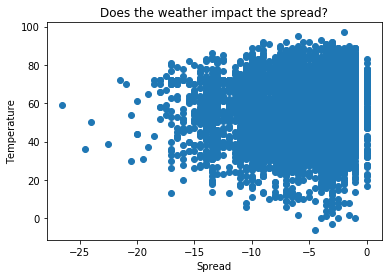

In [11]:
plt.scatter(nfl_spreadspoke['expected_spread_favorite'], nfl_spreadspoke['weather_temperature'])
plt.xlabel('Spread')
plt.ylabel('Temperature')
plt.title('Does the weather impact the spread?')
plt.show()

**In this context, I am testing the correlation and covariance of the spread amount and the temperature. Since the correlation is close to 0, I am assuming that the correlation is negligible. I think this assumption is fair because the spread is often set Tuesday before the game on Sunday which would make it unlikely that it accounts for weather.**

In [12]:
print("Covariance = {:.2f}\nCorrelation = {:.2f}".format(nfl_spreadspoke['expected_spread_favorite'].cov(nfl_spreadspoke['weather_temperature']), nfl_spreadspoke['expected_spread_favorite'].corr(nfl_spreadspoke['weather_temperature'])))

Covariance = 2.89
Correlation = 0.06


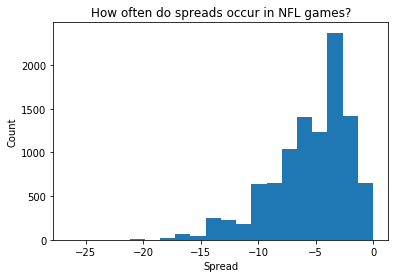

In [13]:
plt.hist(nfl_spreadspoke['expected_spread_favorite'], bins=20)
plt.xlabel('Spread')
plt.ylabel('Count')
plt.title('How often do spreads occur in NFL games?')
plt.show()

In [14]:
home_covered_spreads_fav = []
home_covered_spreads_dog = []
away_covered_spreads_fav = []
away_covered_spreads_dog = []

for index, row in nfl_spreadspoke.iterrows():
    if row['team_home_id'] == row['team_favorite_id'] and row['favorite_covered'] == True:
            home_covered_spreads_fav.append(row['expected_spread_favorite'])
    elif row['team_home_id'] == row['team_favorite_id'] and row['favorite_covered'] == False:
        away_covered_spreads_dog.append(row['expected_spread_favorite'])
    elif row['team_away_id'] == row['team_favorite_id'] and row['favorite_covered'] == True:
        away_covered_spreads_fav.append(row['expected_spread_favorite'])
    elif row['team_away_id'] == row['team_favorite_id'] and row['favorite_covered'] == False:
        home_covered_spreads_dog.append(row['expected_spread_favorite'])

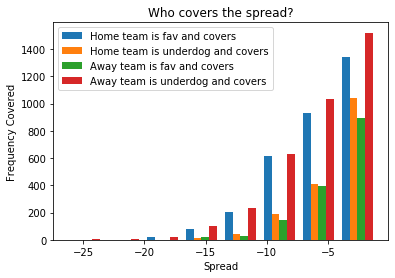

In [15]:
plt.hist([home_covered_spreads_fav,home_covered_spreads_dog,away_covered_spreads_fav,away_covered_spreads_dog], bins = 8, label=['Home team is fav and covers', 'Home team is underdog and covers', 'Away team is fav and covers', 'Away team is underdog and covers'])
plt.xlabel('Spread')
plt.ylabel('Frequency Covered')
plt.title('Who covers the spread?')
plt.legend()
plt.show()

Takeaway from this graph: It is most common for the home team to be favorited and cover or for the away team to be an underdog and cover

In [16]:
most_covered = nfl_spreadspoke['who_covered'].value_counts()[:5].index.tolist()
freq_most_covered = [row['who_covered'] for index, row in nfl_spreadspoke.iterrows() if row['who_covered'] in most_covered]

least_covered = nfl_spreadspoke['who_covered'].value_counts()[27:].index.tolist()
freq_least_covered = [row['who_covered'] for index, row in nfl_spreadspoke.iterrows() if row['who_covered'] in least_covered]


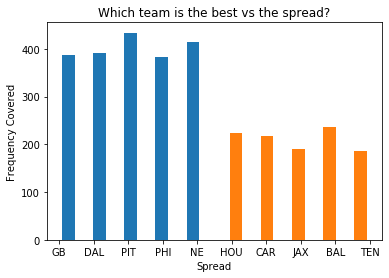

In [17]:
most_covered = nfl_spreadspoke


plt.hist([freq_most_covered, freq_least_covered])
plt.xlabel('Spread')
plt.ylabel('Frequency Covered')
plt.title('Which team is the best vs the spread?')
plt.show()

### <u> Models <u/>

In [18]:
nfl_spreadspoke.head()

,schedule_week,schedule_playoff,team_home_id,team_away_id,team_favorite_id,expected_spread_favorite,favorite_covered,weather_temperature,weather_wind_mph,who_covered
0,Superbowl,True,GB,KC,GB,-14.0,True,54.0,7.0,GB
1,Superbowl,True,GB,LV,GB,-13.5,True,60.0,12.0,GB
2,Superbowl,True,IND,NYJ,IND,-18.0,False,66.0,12.0,NYJ
3,Superbowl,True,KC,MIN,MIN,-12.0,False,55.0,14.0,MIN
4,Superbowl,True,IND,DAL,IND,-2.5,True,59.0,11.0,IND


#### The first model I want to make is a linear regression of the team_favorite_id variable and the who_covered variable

**I need to create a mapping that can map the qualitative team variables to numerical values**

**To do this I can use a new data frame that can match these values**

In [19]:
teams = pd.read_csv('nfl_teams.csv')
teams.head()

,ID,Name,Abbreviation,Conference,Division
0,1,Arizona Cardinals,ARI,NFC,West
1,2,Atlanta Falcons,ATL,NFC,South
2,3,Baltimore Ravens,BAL,AFC,North
3,4,Buffalo Bills,BUF,AFC,East
4,5,Carolina Panthers,CAR,NFC,South


In [20]:
teams = teams[['ID', 'Abbreviation']]
teams = teams.rename(columns={'ID': 'home_team_num','Abbreviation': 'team_home_id'})
teams.head()

,home_team_num,team_home_id
0,1,ARI
1,2,ATL
2,3,BAL
3,4,BUF
4,5,CAR


In [21]:
nfl_spreadspoke = pd.merge(nfl_spreadspoke, teams, how='left', on='team_home_id')
nfl_spreadspoke.head()

,schedule_week,schedule_playoff,team_home_id,team_away_id,team_favorite_id,expected_spread_favorite,favorite_covered,weather_temperature,weather_wind_mph,who_covered,home_team_num
0,Superbowl,True,GB,KC,GB,-14.0,True,54.0,7.0,GB,12
1,Superbowl,True,GB,LV,GB,-13.5,True,60.0,12.0,GB,12
2,Superbowl,True,IND,NYJ,IND,-18.0,False,66.0,12.0,NYJ,14
3,Superbowl,True,KC,MIN,MIN,-12.0,False,55.0,14.0,MIN,16
4,Superbowl,True,IND,DAL,IND,-2.5,True,59.0,11.0,IND,14


In [22]:
teams = teams.rename(columns={'home_team_num': 'away_team_num','team_home_id': 'team_away_id'})
teams.head()

,away_team_num,team_away_id
0,1,ARI
1,2,ATL
2,3,BAL
3,4,BUF
4,5,CAR


In [23]:
nfl_spreadspoke = pd.merge(nfl_spreadspoke, teams, how='left', on='team_away_id')
nfl_spreadspoke.head()

,schedule_week,schedule_playoff,team_home_id,team_away_id,team_favorite_id,expected_spread_favorite,favorite_covered,weather_temperature,weather_wind_mph,who_covered,home_team_num,away_team_num
0,Superbowl,True,GB,KC,GB,-14.0,True,54.0,7.0,GB,12,16
1,Superbowl,True,GB,LV,GB,-13.5,True,60.0,12.0,GB,12,23
2,Superbowl,True,IND,NYJ,IND,-18.0,False,66.0,12.0,NYJ,14,22
3,Superbowl,True,KC,MIN,MIN,-12.0,False,55.0,14.0,MIN,16,18
4,Superbowl,True,IND,DAL,IND,-2.5,True,59.0,11.0,IND,14,9


In [24]:
teams = teams.rename(columns={'away_team_num': 'favorite_num','team_away_id': 'team_favorite_id'})
teams.head()

,favorite_num,team_favorite_id
0,1,ARI
1,2,ATL
2,3,BAL
3,4,BUF
4,5,CAR


In [25]:
pick = pd.DataFrame([[0, 'PICK']], columns=['favorite_num', 'team_favorite_id'])
new_teams = teams.append(pick, ignore_index=True)
print(new_teams)

    favorite_num team_favorite_id
0              1              ARI
1              2              ATL
2              3              BAL
3              4              BUF
4              5              CAR
5              6              CHI
6              7              CIN
7              8              CLE
8              9              DAL
9             10              DEN
10            11              DET
11            12               GB
12            13              HOU
13            14              IND
14            15              JAX
15            16               KC
16            17              MIA
17            18              MIN
18            19               NE
19            20               NO
20            21              NYG
21            22              NYJ
22            23               LV
23            24              PHI
24            25              PIT
25            26              LAC
26            27               SF
27            28              SEA
28            

In [26]:
nfl_spreadspoke = pd.merge(nfl_spreadspoke, new_teams, how='left', on='team_favorite_id')
nfl_spreadspoke.head()

,schedule_week,schedule_playoff,team_home_id,team_away_id,team_favorite_id,expected_spread_favorite,favorite_covered,weather_temperature,weather_wind_mph,who_covered,home_team_num,away_team_num,favorite_num
0,Superbowl,True,GB,KC,GB,-14.0,True,54.0,7.0,GB,12,16,12
1,Superbowl,True,GB,LV,GB,-13.5,True,60.0,12.0,GB,12,23,12
2,Superbowl,True,IND,NYJ,IND,-18.0,False,66.0,12.0,NYJ,14,22,14
3,Superbowl,True,KC,MIN,MIN,-12.0,False,55.0,14.0,MIN,16,18,18
4,Superbowl,True,IND,DAL,IND,-2.5,True,59.0,11.0,IND,14,9,14


In [27]:
teams = teams.rename(columns={'favorite_num': 'who_covered_num','team_favorite_id': 'who_covered'})
nfl_spreadspoke = pd.merge(nfl_spreadspoke, teams, how='left', on='who_covered')
nfl_spreadspoke.head()

,schedule_week,schedule_playoff,team_home_id,team_away_id,team_favorite_id,expected_spread_favorite,favorite_covered,weather_temperature,weather_wind_mph,who_covered,home_team_num,away_team_num,favorite_num,who_covered_num
0,Superbowl,True,GB,KC,GB,-14.0,True,54.0,7.0,GB,12,16,12,12
1,Superbowl,True,GB,LV,GB,-13.5,True,60.0,12.0,GB,12,23,12,12
2,Superbowl,True,IND,NYJ,IND,-18.0,False,66.0,12.0,NYJ,14,22,14,22
3,Superbowl,True,KC,MIN,MIN,-12.0,False,55.0,14.0,MIN,16,18,18,18
4,Superbowl,True,IND,DAL,IND,-2.5,True,59.0,11.0,IND,14,9,14,14


**After the merge, I now have four new columns that I can use: home_team_num and away_team_num, favorite_num, and who_covered_nu**

**Change the true/false values of favorite_covered to 0/1**

In [28]:
favorite_map = {True: 1, False: 0}
nfl_spreadspoke['favorite_covered'] = nfl_spreadspoke['favorite_covered'].map(favorite_map)
nfl_spreadspoke.head()

,schedule_week,schedule_playoff,team_home_id,team_away_id,team_favorite_id,expected_spread_favorite,favorite_covered,weather_temperature,weather_wind_mph,who_covered,home_team_num,away_team_num,favorite_num,who_covered_num
0,Superbowl,True,GB,KC,GB,-14.0,1,54.0,7.0,GB,12,16,12,12
1,Superbowl,True,GB,LV,GB,-13.5,1,60.0,12.0,GB,12,23,12,12
2,Superbowl,True,IND,NYJ,IND,-18.0,0,66.0,12.0,NYJ,14,22,14,22
3,Superbowl,True,KC,MIN,MIN,-12.0,0,55.0,14.0,MIN,16,18,18,18
4,Superbowl,True,IND,DAL,IND,-2.5,1,59.0,11.0,IND,14,9,14,14


**Perform a single variable Logistic Regression**

In [29]:
home_team_model = LogisticRegression(solver='lbfgs').fit(nfl_spreadspoke[ ['favorite_num'] ], nfl_spreadspoke['favorite_covered'])

In [30]:
predictions = home_team_model.predict(nfl_spreadspoke[ ['favorite_num'] ])

In [31]:
def logistic(x):
    return nd.exp(x) / (nd.exp(x) + 1)

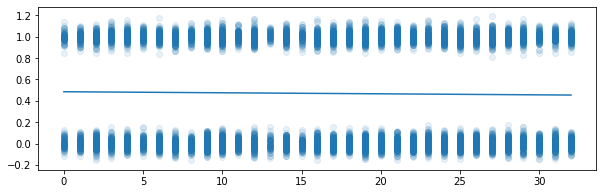

In [32]:
plt.figure(figsize=(10,3))
plt.scatter(nfl_spreadspoke["favorite_num"], nfl_spreadspoke['favorite_covered'] + nd.random.normal(0, 0.05, size=len(nfl_spreadspoke)), alpha=0.1)
x_values = nd.linspace(0,32,32)
plt.plot(x_values, logistic(x_values * home_team_model.coef_[0,0] + home_team_model.intercept_[0]))
plt.show()

In [33]:
print("Regression Coefficient: {:.5f}".format(home_team_model.coef_[0][0]))
print("Regression Intercept: {:.5f}".format(home_team_model.intercept_[0]))

Regression Coefficient: -0.00389
Regression Intercept: -0.05986


**TAKEAWAY: There is no distinguishable relationship created by this regression model. I think I need to add more variables**

In [34]:
nfl_spreadspoke.head()

,schedule_week,schedule_playoff,team_home_id,team_away_id,team_favorite_id,expected_spread_favorite,favorite_covered,weather_temperature,weather_wind_mph,who_covered,home_team_num,away_team_num,favorite_num,who_covered_num
0,Superbowl,True,GB,KC,GB,-14.0,1,54.0,7.0,GB,12,16,12,12
1,Superbowl,True,GB,LV,GB,-13.5,1,60.0,12.0,GB,12,23,12,12
2,Superbowl,True,IND,NYJ,IND,-18.0,0,66.0,12.0,NYJ,14,22,14,22
3,Superbowl,True,KC,MIN,MIN,-12.0,0,55.0,14.0,MIN,16,18,18,18
4,Superbowl,True,IND,DAL,IND,-2.5,1,59.0,11.0,IND,14,9,14,14


**I need to convert the schedule week variable into numerical values**

In [35]:
nfl_spreadspoke['schedule_week'].value_counts()

16            617
15            617
1             616
13            616
2             615
14            614
12            610
11            596
3             566
10            561
9             544
7             542
4             541
8             538
5             530
6             529
17            477
Division      168
Wildcard      150
Conference     84
Superbowl      54
18             14
Name: schedule_week, dtype: int64

In [36]:
week_map = {"1": 1, "2": 2, "3": 3, "4": 4, "5": 5, "6": 6, "7": 7, "8": 8, "9": 9, "10": 10, "11": 11, "12": 12, "13": 13, "14": 14, "15": 15, "16": 16, "17": 17, "18": 18, "Wildcard": 19, "Division": 20, "Conference": 21, "Superbowl": 22}

In [37]:
weeks = nfl_spreadspoke['schedule_week'].map(week_map)
nfl_spreadspoke['week_number'] = weeks

In [38]:
nfl_spreadspoke.head()

,schedule_week,schedule_playoff,team_home_id,team_away_id,team_favorite_id,expected_spread_favorite,favorite_covered,weather_temperature,weather_wind_mph,who_covered,home_team_num,away_team_num,favorite_num,who_covered_num,week_number
0,Superbowl,True,GB,KC,GB,-14.0,1,54.0,7.0,GB,12,16,12,12,22
1,Superbowl,True,GB,LV,GB,-13.5,1,60.0,12.0,GB,12,23,12,12,22
2,Superbowl,True,IND,NYJ,IND,-18.0,0,66.0,12.0,NYJ,14,22,14,22,22
3,Superbowl,True,KC,MIN,MIN,-12.0,0,55.0,14.0,MIN,16,18,18,18,22
4,Superbowl,True,IND,DAL,IND,-2.5,1,59.0,11.0,IND,14,9,14,14,22


**I want to make a dataframe for my model that includes dummy variables for team_home, team_away, and team_favorite**

In [39]:
model_df = nfl_spreadspoke[ ['favorite_covered', 'expected_spread_favorite', 'weather_temperature', 'weather_wind_mph', 'team_home_id', 'team_away_id', 'team_favorite_id', 'week_number'] ]
model_df.head()

,favorite_covered,expected_spread_favorite,weather_temperature,weather_wind_mph,team_home_id,team_away_id,team_favorite_id,week_number
0,1,-14.0,54.0,7.0,GB,KC,GB,22
1,1,-13.5,60.0,12.0,GB,LV,GB,22
2,0,-18.0,66.0,12.0,IND,NYJ,IND,22
3,0,-12.0,55.0,14.0,KC,MIN,MIN,22
4,1,-2.5,59.0,11.0,IND,DAL,IND,22


Creating the dummies and concatonating with the model dataframe

In [40]:
fields = [('team_home_','team_home_id'), ('team_away_','team_away_id'), ('team_favorite_','team_favorite_id')]
for tag, name in fields:
    model_df = pd.concat([model_df, pd.get_dummies(model_df[name], prefix=tag)], axis=1)

In [41]:
model_df.head()

,favorite_covered,expected_spread_favorite,weather_temperature,weather_wind_mph,team_home_id,team_away_id,team_favorite_id,week_number,team_home__ARI,team_home__ATL,...,team_favorite__NYG,team_favorite__NYJ,team_favorite__PHI,team_favorite__PICK,team_favorite__PIT,team_favorite__SEA,team_favorite__SF,team_favorite__TB,team_favorite__TEN,team_favorite__WAS
0,1,-14.0,54.0,7.0,GB,KC,GB,22,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,-13.5,60.0,12.0,GB,LV,GB,22,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,-18.0,66.0,12.0,IND,NYJ,IND,22,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,-12.0,55.0,14.0,KC,MIN,MIN,22,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,-2.5,59.0,11.0,IND,DAL,IND,22,0,0,...,0,0,0,0,0,0,0,0,0,0


**I now want to make a multi-logistic model. I am going to use week, home team, away team, team favorite, spread, temperature and weather to predict whether the favorite covers (favorite_covered = 1).**

In [42]:
predictor_variables = list(model_df.columns)
predictor_variables.remove('team_home_id')
predictor_variables.remove('team_away_id')
predictor_variables.remove('team_favorite_id')
predictor_variables.remove('favorite_covered')
print(predictor_variables)

['expected_spread_favorite', 'weather_temperature', 'weather_wind_mph', 'week_number', 'team_home__ARI', 'team_home__ATL', 'team_home__BAL', 'team_home__BUF', 'team_home__CAR', 'team_home__CHI', 'team_home__CIN', 'team_home__CLE', 'team_home__DAL', 'team_home__DEN', 'team_home__DET', 'team_home__GB', 'team_home__HOU', 'team_home__IND', 'team_home__JAX', 'team_home__KC', 'team_home__LAC', 'team_home__LAR', 'team_home__LV', 'team_home__MIA', 'team_home__MIN', 'team_home__NE', 'team_home__NO', 'team_home__NYG', 'team_home__NYJ', 'team_home__PHI', 'team_home__PIT', 'team_home__SEA', 'team_home__SF', 'team_home__TB', 'team_home__TEN', 'team_home__WAS', 'team_away__ARI', 'team_away__ATL', 'team_away__BAL', 'team_away__BUF', 'team_away__CAR', 'team_away__CHI', 'team_away__CIN', 'team_away__CLE', 'team_away__DAL', 'team_away__DEN', 'team_away__DET', 'team_away__GB', 'team_away__HOU', 'team_away__IND', 'team_away__JAX', 'team_away__KC', 'team_away__LAC', 'team_away__LAR', 'team_away__LV', 'team

**I want to split my data into train and test data**

In [43]:
multi_train, multi_test = train_test_split(model_df, test_size = 0.1)

In [44]:
multi_model = LogisticRegression(solver='liblinear').fit(multi_train[predictor_variables], multi_train['favorite_covered'])

These show the affect of each predictor variable on the output

In [45]:
for i, predictor in enumerate(predictor_variables):
    print("{:.4f}\t{}".format(multi_model.coef_[0,i], predictor))
print("Intercept = {:.5f}".format(multi_model.intercept_[0]))

0.0096	expected_spread_favorite
-0.0008	weather_temperature
0.0010	weather_wind_mph
0.0068	week_number
0.0336	team_home__ARI
0.1003	team_home__ATL
0.0600	team_home__BAL
0.1343	team_home__BUF
-0.0393	team_home__CAR
-0.0496	team_home__CHI
0.1656	team_home__CIN
0.2008	team_home__CLE
-0.0344	team_home__DAL
-0.1767	team_home__DEN
0.0737	team_home__DET
0.2105	team_home__GB
-0.3600	team_home__HOU
0.0393	team_home__IND
0.2203	team_home__JAX
-0.3341	team_home__KC
0.0330	team_home__LAC
0.3947	team_home__LAR
0.0566	team_home__LV
-0.2139	team_home__MIA
-0.0456	team_home__MIN
-0.2394	team_home__NE
-0.1177	team_home__NO
0.0668	team_home__NYG
-0.2152	team_home__NYJ
-0.1197	team_home__PHI
0.1475	team_home__PIT
-0.2207	team_home__SEA
-0.1012	team_home__SF
0.1432	team_home__TB
0.2792	team_home__TEN
-0.1920	team_home__WAS
0.1743	team_away__ARI
-0.0624	team_away__ATL
-0.3841	team_away__BAL
0.0250	team_away__BUF
-0.1343	team_away__CAR
0.1157	team_away__CHI
0.0620	team_away__CIN
0.1825	team_away__CLE
-0.094

## Evaluation of Significance

For my significance, I want to simulate a betting season with my testing data that uses the model "multi_model." To do this I want to use three different criteria when determining when to make a bet. In one scenario, I want to make bets only when the model produces there is a greater than 0.55 outcome or less than 0.45 outcome. In another, the model must be greater than 0.6 or less than 0.4. In the last scenario, the model must be greater 0.7 or less than 0.3. I am going to track the number of bets made as well as the number of bets that hit to see the accuracy and usability of the model in pratice.

In [46]:
total_test_games = len(multi_test)
scenario1_bets, scenario1_hits, scenario2_bets, scenario2_hits, scenario3_bets, scenario3_hits, = 0,0,0,0,0,0

**<u>Scenario 1**

In [47]:
multi_test.head()

,favorite_covered,expected_spread_favorite,weather_temperature,weather_wind_mph,team_home_id,team_away_id,team_favorite_id,week_number,team_home__ARI,team_home__ATL,...,team_favorite__NYG,team_favorite__NYJ,team_favorite__PHI,team_favorite__PICK,team_favorite__PIT,team_favorite__SEA,team_favorite__SF,team_favorite__TB,team_favorite__TEN,team_favorite__WAS
5982,1,-4.0,50.0,5.0,PIT,CIN,PIT,4,0,0,...,0,0,0,0,1,0,0,0,0,0
4506,0,-6.5,72.0,6.0,JAX,TB,JAX,11,0,0,...,0,0,0,0,0,0,0,0,0,0
4946,1,-4.0,74.0,13.0,KC,SEA,KC,5,0,0,...,0,0,0,0,0,0,0,0,0,0
3290,0,-2.5,72.0,0.0,MIN,NO,MIN,13,0,0,...,0,0,0,0,0,0,0,0,0,0
1315,0,-2.0,56.0,16.0,LAC,KC,LAC,16,0,0,...,0,0,0,0,0,0,0,0,0,0


**This function will allow me to perform repeated analysis on my model, by specifiying the accuracy threshold.**

In [48]:
def analysis(test, actual_data, accuracy, bets, hits):
    for i in range(len(test)):
        if test[i] >= (0.5 + accuracy) or test[i] <= (0.5 - accuracy):
            bets += 1
        if test[i] >= (0.5 + accuracy) and actual_data[i] == 1:
            hits += 1
        if test[i] <= (0.5 - accuracy) and actual_data[i] == 0:
            hits += 1
    arr = [bets, hits]
    return arr

**This should return a multi-dimensional array with the first column being the probability the prediction is 0 and the second column being the probability is 1**

In [49]:
predictions_probability_test = multi_model.predict_proba(multi_test[predictor_variables])[:,1]
actual = list(multi_test['favorite_covered'])

In [53]:
print(analysis(predictions_probability_test, actual, 0.05, scenario1_bets, scenario1_hits))

[420, 213]


In [54]:
print(analysis(predictions_probability_test, actual, 0.1, scenario2_bets, scenario2_hits))

[119, 64]


In [55]:
print(analysis(predictions_probability_test, actual, 0.2, scenario3_bets, scenario3_hits))

[6, 5]


**Results from test data**

In [56]:
test_bets = [
             analysis(predictions_probability_test, actual, 0.05, scenario1_bets, scenario1_hits)[0],
             analysis(predictions_probability_test, actual, 0.1, scenario2_bets, scenario2_hits)[0],
             analysis(predictions_probability_test, actual, 0.2, scenario3_bets, scenario3_hits)[0]
            ]
test_hits = [
             analysis(predictions_probability_test, actual, 0.05, scenario1_bets, scenario1_hits)[1],
             analysis(predictions_probability_test, actual, 0.1, scenario2_bets, scenario2_hits)[1],
             analysis(predictions_probability_test, actual, 0.2, scenario3_bets, scenario3_hits)[1]
            ]

In [57]:
for i in range(3):
    print("Scenario {}:".format(i+1))
    print("\tBets Placed: {}".format(test_bets[i]))
    print("\tBets Hit: {}".format(test_hits[i]))
    print("\tBet Percentage: {:.2%}".format(test_bets[i]/total_test_games))
    print("\tHit Percentage: {:.2%}".format(test_hits[i]/test_bets[i]))

Scenario 1:
	Bets Placed: 420
	Bets Hit: 213
	Bet Percentage: 41.18%
	Hit Percentage: 50.71%
Scenario 2:
	Bets Placed: 119
	Bets Hit: 64
	Bet Percentage: 11.67%
	Hit Percentage: 53.78%
Scenario 3:
	Bets Placed: 6
	Bets Hit: 5
	Bet Percentage: 0.59%
	Hit Percentage: 83.33%


**Now I am going to run these same simulations on the 10 sets of test data and average the results**

In [58]:
scen1_bets, scen1_hits, scen2_bets, scen2_hits, scen3_bets, scen3_hits = 0,0,0,0,0,0
for i in range(10):
    new_train, new_test = train_test_split(model_df, test_size = 0.1)
    predictions_prob = multi_model.predict_proba(new_test[predictor_variables])[:,1]
    total_games = len(multi_test)
    scenario1_bets, scenario1_hits, scenario2_bets, scenario2_hits, scenario3_bets, scenario3_hits, = 0,0,0,0,0,0
    
    scen1_bets += analysis(predictions_prob, actual, 0.05, scenario1_bets, scenario1_hits)[0]
    scen1_hits += analysis(predictions_prob, actual, 0.05, scenario1_bets, scenario1_hits)[1]
    scen2_bets += analysis(predictions_prob, actual, 0.1, scenario2_bets, scenario2_hits)[0]
    scen2_hits += analysis(predictions_prob, actual, 0.1, scenario2_bets, scenario2_hits)[1]
    scen3_bets += analysis(predictions_prob, actual, 0.2, scenario3_bets, scenario3_hits)[0]
    scen3_hits += analysis(predictions_prob, actual, 0.2, scenario3_bets, scenario3_hits)[1]

In [59]:
iter_total_bets = [scen1_bets, scen2_bets, scen3_bets]
iter_total_hits = [scen1_hits, scen2_hits, scen3_hits]

In [60]:
for i in range(3):
    print("Scenario {}:".format(i+1))
    print("\tTotal Bets Placed: {}".format(iter_total_bets[i]))
    print("\tTotal Bets Hit: {}".format(iter_total_hits[i]))
    print("\tAverage Bet Percentage: {:.2%}".format(iter_total_bets[i] / (total_test_games * 10)))
    print("\tAverage Hit Percentage: {:.2%}".format(iter_total_hits[i] / iter_total_bets[i]))

Scenario 1:
	Total Bets Placed: 4470
	Total Bets Hit: 2340
	Average Bet Percentage: 43.82%
	Average Hit Percentage: 52.35%
Scenario 2:
	Total Bets Placed: 1125
	Total Bets Hit: 623
	Average Bet Percentage: 11.03%
	Average Hit Percentage: 55.38%
Scenario 3:
	Total Bets Placed: 79
	Total Bets Hit: 52
	Average Bet Percentage: 0.77%
	Average Hit Percentage: 65.82%


If I chose to bet 10$ on every game, what would have happened?

In [61]:
revenue = 0
cost = 0
for i in range(3):
    revenue += iter_total_hits[0] * 10
    cost += (iter_total_bets[0] - iter_total_hits[0]) * 10
profit = revenue - cost
print('Profit with $10 Unit = ${}'.format(profit))

Profit with $10 Unit = $6300


There are 267 games in an nfl season, so how much on average would I make in 1 season using all three scenarios?

In [62]:
seasons = total_test_games / 267
profit_per_szn = profit / seasons
print('Average Profit per Season with a $10 unit = ${:.2f}'.format(profit_per_szn))

Average Profit per Season with a $10 unit = $1649.12


**Now I want to test what would happen if I just bet on the favorite every time or on the underdog everytime**

In [63]:
favorite_every_time = 0
dog_every_time = 0
for index, row in nfl_spreadspoke.iterrows():
    if row['favorite_covered'] == True:
        favorite_every_time += 1
    else:
        dog_every_time += 1

In [64]:
print('Favorite Percent = {:.2%}'.format(favorite_every_time / len(nfl_spreadspoke['favorite_covered'])))
print('Dog Percent = {:.2%}'.format(dog_every_time / len(nfl_spreadspoke['favorite_covered'])))

Favorite Percent = 46.85%
Dog Percent = 53.15%


**Takeaway from this analysis: Both my scenario 2 and scenario 3 models outperform just betting on the underdog everytime.**

## Interpretations and Conclusions

During my analysis I created a model that can accurately predict over the long-term winners of NFL games based on the spread. In my opinion, this is a success. The model would be intended for long-term use, meaning that it would need to be implemented over an entire season or more for value to be truly recognized

The analysis found that if I simply chose to bet the favorite every time or the underdog every time, I would be successful 47% and 53% of the time respectively. Long-term, this strategy is not viable.

Upon creation of my model, I ran a single test to determine how successful I would be with three confidence thresholds. In one scenario, I told the model to make a "bet" if it was either more than 55% confident the favorite would cover or less than 45% confident. If it was more than 55%, it would bet on the favorite, and if it was less than 45%, it would bet on the underdog. Using this system, the model determined I should bet around 45% of the time and resulted in a success rate of 53.41%.

The second scenario required more confidence in order to make a bet. The model was only supposed to "bet" if the confidence was greater than 60% or less than 40%. The model decided to bet on 11% of the games with a success rate of 61.4%

The last scenario required the greatest amount of confidence: greater than 70% or less than 30%. This scenario resulted in a tiny bet percentage, 0.88%, but hit almost 67% of the time.

However, these results were from just one set of testing data. To be more confident, I ran 10 more simulations on random testing data, using the same scenarios as the first time. On average, scenario 1 resulted in betting 45% of games and hitting 51% of the time. Scenario 2 on average resulted in betting 11% of the games and hitting 55% of the time. Scenario 3 resulted in betting on average 0.68% of the games and hitting almost 60% of the time.

Finally, I wanted to determine how profitable I would be if I used this model long-term. I calculated, on average, if my unit was betting ten dollars a game, I would profit 966 dollars every season.

I am pretty confident in my results because of the many simulations I have run to determine that the results are not a fluke. With any gambling model, you do not need an extremely high hit percentage, you just need a large enough margin to be profitable long-term. I think I have successfully achieved such a model and am excited to attempt to use it this current NFL season.

## Limitations

The main limitation of my study is that I am using historical team data. This means that the model is taking into account a teams historical performances against the spread and using it to determine what will happen in the future. However, this might not always be a great way to use the data. For example, the Clevland Browns are a historically bad franchise; however, they have a very good team right now. Therefore, the model might not account for the Browns turing their team around.

Another limitation is that I only have high level statistics. I have the home and away teams as well as the schedule week and weather. However, these stats are not indicative of what will happen during the actual course of the game. If the dataset was larger, I could have included the teams individual record at the time of the game and player statistics. For example, if a team has the leagues MVP, that will probably affect how often they cover a spread. The dataset also could be more robust by including player injuries. Injuries often have large impacts on teams throughout the course of the season, yet my model does not account for any of them.

Finally, there is a bias in my data cleaning that affects my overall outcome model. I remove many columns in the original data set such as weather type (such as rain, snow, cloudy, etc.) and the over/under line that I assumed did not matter and did not want to analyze. In football, the over/under line is another gambling line that allows viewers to bet on the total amount of points scored in a particular game. I now think that this line would have a noticable effect on the outcome of the spread because if the spread is set high (ie. -14) and the over/under line is only 38, it will be very difficult for the favorite to cover because they must score pretty much all the points in the game.

## Source Code

I do not have a github repo. All my code is in this file or in the appendix I am submitting that contains my data cleaning description

## Acknowledements

In creating this project, I used countless stack overflow pages, pandas and numpy documentation, and several medium tutorials. I also used a similar kaggle betting model to give me inspiration for my own model https://www.kaggle.com/twalters20/nfl-betting-model.